## 抓取富邦人壽問答集

In [3]:
import requests
res = requests.get('https://www.fubon.com/life/direct/Faq.html')
res.encoding

'ISO-8859-1'

In [5]:
res.encoding = 'utf-8'
#res.text

In [6]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(res.text, 'lxml')

In [11]:
questions = [q.text for q  in soup.select('.faq__q')]
#questions

In [15]:
answers = [q.text.strip() for q  in soup.select('.faq__a')]

In [19]:
qa_ary = []
for q, a in zip(questions, answers):
    qa_ary.append({'questions':q,'answer':a})

In [21]:
import pandas
qa_df = pandas.DataFrame(qa_ary)
qa_df.to_excel('fubonqa.xlsx')

## 產生一個自動問答機器人

In [22]:
import pandas
fubonqa = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/fubonpy/master/data/fubonqa.xlsx')

In [40]:
import jieba

q = '請問要保人是什麼?'

corpus    = [' '.join(jieba.cut(q))]
questions = [q]
answers   = ['DUMMY']
for rec in fubonqa.iterrows():
    corpus.append(' '.join(jieba.cut(rec[1].questions)))
    questions.append(rec[1].questions)
    answers.append(rec[1].answer)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X

<31x114 sparse matrix of type '<class 'numpy.int64'>'
	with 183 stored elements in Compressed Sparse Row format>

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(X[0], X)
pos = cs[0].argsort()[::-1][1]
questions[pos]
answers[pos]

'要保人是指對保險標的具有保險利益，向保險人申請訂立保險契約，並負有交付保險費義務之人。'

In [51]:
import jieba

q = '請問要保人是什麼?'

def autoQA(q,threshold):
    corpus    = [' '.join(jieba.cut(q))]
    questions = [q]
    answers   = ['DUMMY']
    for rec in fubonqa.iterrows():
        corpus.append(' '.join(jieba.cut(rec[1].questions)))
        questions.append(rec[1].questions)
        answers.append(rec[1].answer)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    cs = cosine_similarity(X[0], X)
    pos = cs[0].argsort()[::-1][1]
    if cs[0][pos] > threshold:
        return answers[pos]
    else:
        return '我現在還在學習您的問題, 等我變聰明以後我就可以回答您了'

In [53]:
autoQA('請問要保人是什麼?', 0.5)

'要保人是指對保險標的具有保險利益，向保險人申請訂立保險契約，並負有交付保險費義務之人。'

In [54]:
autoQA('請問今天天氣好嗎', 0.5)

'我現在還在學習您的問題, 等我變聰明以後我就可以回答您了'

## 產生一個可對話機器人

In [58]:
import speech_recognition as sr
def listenToMe():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        print("請說出您的問題!")
        audio = r.listen(source)
    return r.recognize_google(audio, language='zh-TW')

In [59]:
listenToMe()

請說出您的問題!


'請問什麼是要保人'

In [60]:

from gtts import gTTS
from pygame import mixer
mixer.init()

import tempfile
def speak(sentence):
    with tempfile.NamedTemporaryFile(delete=True) as fp:
        tts = gTTS(text=sentence, lang='zh')
        tts.save("{}.mp3".format(fp.name))
        mixer.music.load('{}.mp3'.format(fp.name))
        mixer.music.play()
speak('大家好')

In [67]:
speak(autoQA(listenToMe(), 0.5))

請說出您的問題!


## 新聞分群

In [78]:
import requests
from bs4 import BeautifulSoup
res = requests.get('https://raw.githubusercontent.com/ywchiu/fuboni/master/data/1435449602.xml')

In [97]:
from xml.dom import minidom
from xml.etree import ElementTree
import jieba.analyse
import re

events=ElementTree.fromstring(res.text)

corpus = []
titles = []
for elem in events.findall('./channel/item'):
    title       = elem.find('title').text
    description = elem.find('description').text
    ## original
    #corpus.append(' '.join(jieba.cut(description)))
    
    ## filter out non-chinese word
    #ary = []
    #for w in jieba.cut(description):
    #    m = re.match('^[\u4e00-\u9fa5]+$', w)
    #    if m:
    #        ary.append(w)
    #corpus.append(' '.join(ary))
    
    ## recommend method
    corpus.append(' '.join([w for w in jieba.cut(description) \
                            if re.match('^[\u4e00-\u9fa5]+$', w)]))
    titles.append(title)

In [98]:
corpus[0]

'新北市 八仙 水上 樂園 昨晚 發 生粉 塵 爆炸 新北市 衛生局 統計 到 目前 為止 由 救護車 送 醫再 加上 自行 送醫 的 人數 已經 有 人 其中 人 重傷 而 新北市 長 朱立倫 昨晚 到 現場 坐鎮 指揮 了解 狀況 並馬上 要求 追究 責任 徹查 並要 八仙 樂園 立刻 關園 停業 八仙 樂園 業者 雖然 表示 活動 是 外包 的 但 也 說 會 配合 暫時 停止 營業 接受 調查 警方 今天 凌晨 也 帶 回 五名 相關 人 漏夜 偵訊 包括 現場 呂姓 活動 負責人 邱姓 硬體 設備 人員 和 廖姓 特效 人員 以及 兩名 在 現場 噴灑 彩色 粉塵 的 名 工作 人員 訊後將 依業務 過失 重大 傷害 與 公共 危險 罪嫌 偵辦 統一 移送 士林 地檢署 檢警 偵辦 重點 在 於 主辦 單位 辦 這個 活動時 到底 有 沒 有 做好 安全 上 的 防備 據 了解 主辦 人 表示 彩色 派 對 今年 是 第四次 舉辦 去年 也 才 在 高雄 西子 灣辦過 不 知道 為何 這次 會 造成 這麼 嚴重 的 意外 但 警方 對 這樣 的 說法 保留 態度 而 士林 地檢署 今天 凌晨 也 已經 由 名檢察官 連夜 到 八仙 樂園 了解 情況 並 扣押 噴發 氣體 和 粉塵 的 鋼瓶 據 了解 檢方 人員到 現場 後 發現 舞台 設在 游泳池 中間 其實 等 於 是 半密閉 空間 而且 地上 四散 菸 蒂 和 打火 機 不 排除 是 有人 不慎 點 菸 引燃 造成 這次 的 意外 而 外界 關注 昨晚 現場 到底 有 沒 有 在 舞台 上 噴火 據 了解 昨晚 器材 中並 沒有 火焰 效果器 檢警 初步 研判 辦 趴用 的 粉彩 主要 成分 為 玉米粉 在 一定 的 空間 一定 的 濃度 遇到 靜電 或 火花 不用 高溫 就 很 容易 引發 閃燃 現象 可能 是 大量 接觸 熱能 像是 舞台 光源 器材 電流 點 菸 等 引發 爆炸 但 詳細 起火 原因 和 起火 點 還是 要 經由 火場 鑑識 釐 清 檢警 近期 將陸續 傳喚 傷者 並調 閱監 視錄 影畫面 了解 事發 經過'

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X

<147x12245 sparse matrix of type '<class 'numpy.int64'>'
	with 22679 stored elements in Compressed Sparse Row format>

In [101]:
#vectorizer.get_feature_names()

In [102]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(X)
cs

array([[ 1.        ,  0.16031292,  0.00604056, ...,  0.25165992,
         0.0303501 ,  0.02004996],
       [ 0.16031292,  1.        ,  0.02020511, ...,  0.1933817 ,
         0.03806935,  0.02235509],
       [ 0.00604056,  0.02020511,  1.        , ...,  0.01585904,
         0.        ,  0.        ],
       ..., 
       [ 0.25165992,  0.1933817 ,  0.01585904, ...,  1.        ,
         0.03984095,  0.05263968],
       [ 0.0303501 ,  0.03806935,  0.        , ...,  0.03984095,
         1.        ,  0.31318412],
       [ 0.02004996,  0.02235509,  0.        , ...,  0.05263968,
         0.31318412,  1.        ]])

In [108]:
from sklearn import cluster
c = cluster.KMeans(n_clusters = 4, init='k-means++')

In [109]:
grp = c.fit_predict(cs)

In [117]:
import numpy as np
titles_ary = np.array(titles)
#titles_ary[grp]
#grp  == 2
for t in titles_ary[grp  == 1]:
    print(t)

台鐵新基隆車站29日正式啟用
基改不算真食物  法國人知情就不買
女子世界盃足球賽  日擊敗澳洲晉4強
《農民曆小幫手》國曆六月二十八日
江蕙得「特別貢獻獎」 感恩金曲肯定她
大台北今高溫上探37度
羅志祥哭了 蔡依林讚表現很好
風評：陷入獵巫遊戲的中資認定
挪威「行動大雕」出沒 隨機射路人
還是熱！西半部高溫達37度
德國即將關閉使用最久核子反應爐
張娟芬專文：抽絲剝繭邱和順案
2015空姐夏裝大盤點
觀點投書：讀中文系的人，應該反對課綱微調
觀點投書：何謂新兵訓練
觀點投書：災難中的護理人
呂政璋觀點：點土成金新思維~以台灣柳丁為例
觀點投書：招搖的進步
中俄美競造5音速機彈
手相看什麼樣的女人性格強勢
面相看哪些人財運綿長不盡
【美洲盃八強】巴西 VS. 巴拉圭 線上直播！
塔羅占卜你今生最看重的是什麼
蘇塞大屠殺 凶手畫面曝光
塔羅占卜你是個有心機的人嗎？
挑選新鮮食物 大有學問
調心養心 初夏多吃蔬果
夏天吃什麼好 紅棗、苦瓜攏總來
補鈣能手大比拚 牛奶吸收效果好
暑假應考季 小心體內酸鹼失衡
水果中的皇后 草莓多食好處多
旺報觀點－鄭弘儀！別讓台灣人背黑鍋！
古人愛西瓜 清明上河圖可佐證
旺報觀點－紀念抗戰 台日中獲和解轉機
陸官淪陪酒郎 2年10起醉死案
慈禧愛西瓜盅 一天可吃數十個
紀念抗戰 學者：反省、避免戰爭
多位台老兵 受邀赴陸閱兵
陸祭出新規 能上能下整肅官場
首例 馬頒紀念章給新四軍老兵
陸改革遇5瓶頸 難以落實基層
金蟬花替代蟲草 浙民服用中毒
鄭弘儀反紀念抗戰 陸批數典忘祖
《經濟教室》白居易、蘇東坡看加薪
大陸》A股紅火 中資想回家
大陸》華人赴美置產不手軟
北美》線上貸款業搶飯碗
北美》加州光熱發電受挫
歐洲》高貴的徵才條件
東北亞》大眾運輸費變貴了
歐洲》荷蘭的稻田發電
一周大事－6月21日至27日
社論－真道理性真愛台灣系列 7 打一場讓社會公平的
有話要說－別害警察不敢用槍
中間選民為洪秀柱按讚
學生心態M化 台大有責任
莫忘來時路／6月28日－先上車後補票成歷史
短評－柯P 去上海吧
花蓮民宅火警 1男嗆昏送醫
新生代性感女神降臨　男粉絲擠爆簽書會
屏東樂遊東港 住民宿探蚵殼島
競選總部入厝　洪慈庸期許台中煥然一新
超商父親節早鳥預購開跑　聶永真設計商品再次收藏
八里爆炸意外衛生局凌晨公布314名傷患名單 分送27
「我不說

In [120]:
from sklearn import cluster
c = cluster.KMeans(n_clusters = 10, init='k-means++')
grp = c.fit_predict(cs)

import numpy as np
titles_ary = np.array(titles)
#for g in range(1,11):
#    print('group:', g)
#    for t in titles_ary[grp  == g]:
#        print(t)
#    print('=============================')

## Silhouette
- a: 群內的距離
- b: 群間的距離
- sil = (b - a) / (max(b, a))
- sil == 1: 每個點為各自的群
- sil == 0: 當群間的距離 == 群內距離

In [127]:
from sklearn.metrics import silhouette_score

sil_ary = []
for k in range(2,21):
    c = cluster.KMeans(n_clusters = k, init='k-means++')
    grp = c.fit_predict(cs)
    sil_ary.append({'group':k,'silhouette':silhouette_score(cs, labels=grp)})

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rec', 'title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


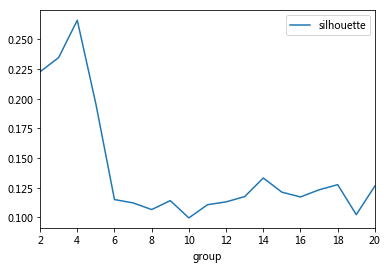

In [130]:
% pylab inline
import pandas
sil_df = pandas.DataFrame(sil_ary)
sil_df.plot(kind = 'line', x='group', y='silhouette')

In [131]:
sil_df.head()

,group,silhouette
0,2,0.222693
1,3,0.234709
2,4,0.266141
3,5,0.195605
4,6,0.115052


## 針對新聞資料分群

In [132]:
import pandas
appledaily = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/fuboni/master/data/appledaily20171214.xlsx')

In [138]:
corpus = []
titles = []
for news in appledaily.iterrows():
    title = news[1]['title']
    content = news[1]['content']
    corpus.append(' '.join([w for w in jieba.cut(content) \
                            if re.match('^[\u4e00-\u9fa5]+$', w)]))
    titles.append(title)

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [189]:
X

<899x36366 sparse matrix of type '<class 'numpy.int64'>'
	with 120587 stored elements in Compressed Sparse Row format>

In [141]:
#vectorizer.get_feature_names()

In [142]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(X)

In [143]:
from sklearn.metrics import silhouette_score

sil_ary = []
for k in range(2,21):
    c = cluster.KMeans(n_clusters = k, init='k-means++')
    grp = c.fit_predict(cs)
    sil_ary.append({'group':k,'silhouette':silhouette_score(cs, labels=grp)})

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


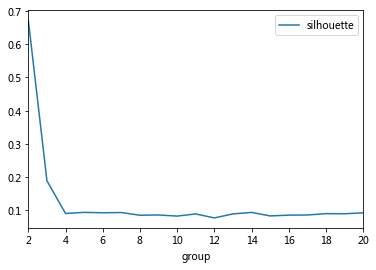

In [144]:
% pylab inline
import pandas
sil_df = pandas.DataFrame(sil_ary)
sil_df.plot(kind = 'line', x='group', y='silhouette')

In [145]:
c = cluster.KMeans(n_clusters = 3, init='k-means++')
grp = c.fit_predict(cs)

In [151]:
import numpy as np
titles_ary = np.array(titles)
for ele in titles_ary[grp == 0]:
    print(ele)

小嫻婚變冒毒菇　勾于美人「奉茶」夢魘
人妻離婚5個月產女　他驚覺頭上綠綠der
醉女盧小小　女警帥爆！突然霸氣送她側摔　
遭粉絲頁冒名捲「正嫻」口水戰　于美人：跟我真的無關！
明明是好康分享文　網友卻瘋喊噁心慎入
「想抱孫要看天！」　他批小嫻婆婆殘忍強逼
砲轟小嫻被酸民攻陷　「何三姑」粉絲頁關了
【好聚不好散】離婚掏出6千萬　這女星比小嫻還慘
【狗仔偷拍】小嫻搬離何守正家租66坪房　月租6萬元
許聖梅心疼小嫻被當空氣　爆何守正「有兩個女學員」
【動畫解盤】毒菇跳火線譙seafood　小嫻難瘦香菇
十二月十四日各報頭條搶先報
不捨善良小嫻慘遭婚變　乃哥「命運捉弄人」
【獨家】小嫻賣房求子　婆婆竟拒入籍何家
【毒菇護弟】何守正姊姊不是華岡七仙女　美法連線批小嫻
員工開勞斯萊斯連撞3次　剉！他老闆是治平大哥　
小嫻離婚導火線　拉何守正信妙禪
【狗仔偷拍】何守正現身！「全台最沒尊嚴的婆婆」也出來了
小嫻中分手魔咒！ 同公司4女星全都婚變
他因為小嫻婚變被分手　網友跪求：拜託別放生
潔哥目睹「正嫻之變」　驚呼：靠北系列竟是真的
何守正姐姐神護航！遭網友酸：全台最討人厭大姑
小嫻別傻傻被欺負！女律師說「姐寶」就要這樣對付
【小嫻婚變】他說很奇怪　「一定是男生劈腿？」
教友小嫻婚姻觸礁　曾之喬談情避不開Seafood
小嫻守正結婚在台沒登記　想離婚只有兩條路
胡瓜2個月前耳聞小嫻婚變　震驚之餘好心疼
昔日搭檔談小嫻婚變　曾國城這樣說
何守正兩個姊姊護航扯婆媳　「他」戳破媽寶特色
大姑出面護弟！轟小嫻不能生「媽媽是全台最沒有尊嚴的婆婆」
小嫻信奉妙禪　關鍵原因與何守正有關！
心酸！臉書認證邊緣人　網友高調幫QQ
小嫻何守正想離婚　必須先做這件事！
「老娘就是不嫁人！」超霸氣春聯讓人暴動了
【K律師論點】離婚＝失敗？　K律師這麼說
夾娃娃機無極限　網友驚呼：永澤4ni！
真尷尬！他只是聊個天　正妹就退出對話了
女網紅因為這理由挺余祥銓！讓人不知該哭還是笑
做辛酸？薪水被扣1萬　還要繳水電瓦斯費
「小嫻不快樂！」　許聖梅：何守正虧欠她
一下車有人墜樓掉在車頂　網友：車牌有密碼
【內幕動畫】小嫻婚變何守正姊反擊　不滿媽煮飯侍奉星媳婦
小嫻多信妙禪？　曾見證「師父帶我跳舞」
【話當年】被拍和她上賓館　何守正掰了阿妹
小嫻婚變無徵兆　男星嘆：兩人向來出雙入對
【獨家內幕】太傷！小嫻被分手　何

## 社群偵測法

In [156]:
m = (cs >= 0.5).astype(int)

In [163]:
import networkx as nx
#G = nx.Graph()
G = nx.from_numpy_matrix(m)

In [166]:
nx.write_graphml(G, 'news.graphml')

### 安裝 python-louvain
- pip install python-louvain

In [167]:
! pip install python-louvain

In [184]:
import community
grp = community.best_partition(G)
grp_ary = np.array(list(grp.values()) )

In [186]:
from collections import Counter
c = Counter(list(grp.values()))
for g, cnt in c.most_common(10):
    print('group:', g)
    articles = titles_ary[grp_ary == g]
    for news in articles:
        print(news)
    print('================================')

group: 3
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
group: 70
【狗仔偷拍】小嫻搬離何守正家租66坪房　月租6萬元
許聖梅心疼小嫻被當空氣　爆何守正「有兩個女學員」
【動畫解盤】毒菇跳火線譙seafood　小嫻難瘦香菇
【獨家】小嫻賣房求子　婆婆竟拒入籍何家
小心！在美結婚台灣沒登記　偷腥照樣能捉姦
小嫻離婚導火線　拉何守正信妙禪
小嫻守正結婚在台沒登記　想離婚只有兩條路
大姑出面護弟！轟小嫻不能生「媽媽是全台最沒有尊嚴的婆婆」
小嫻信奉妙禪　關鍵原因與何守正有關！
小嫻何守正想離婚　必須先做這件事！
【內幕動畫】小嫻婚變何守正姊反擊　不滿媽煮飯侍奉星媳婦
小嫻婚變無徵兆　男星嘆：兩人向來出雙入對
【獨家內幕】太傷！小嫻被分手　何守正當小三面前攤牌
【小嫻離婚】何守正稱沒有遺憾　人妻女星超火「一嘴屁話」
【小嫻離婚】3大退讓人財兩失　求子花光430萬積蓄
group: 114
驚！　野生捕獲恐龍遛汪星人
驚！　野生

## 找出每群出現最多的字眼

In [188]:
len(grp_ary == 70)

899

In [195]:
occurence_cnt = X[grp_ary == 70].toarray().sum(axis = 0)

In [200]:
top10_word = occurence_cnt.argsort()[::-1][0:10]

In [202]:
terms = np.array(vectorizer.get_feature_names())
terms[top10_word]

array(['小嫻', '何守', '離婚', '結婚', '美國', '何家', '表示', '時間', '台灣', '自己'], 
      dtype='<U7')

In [203]:
from collections import Counter
terms = np.array(vectorizer.get_feature_names())
c = Counter(list(grp.values()))
for g, cnt in c.most_common(10):
    print('group:', g)
    articles = titles_ary[grp_ary == g]
    occurence_cnt = X[grp_ary == g].toarray().sum(axis = 0)
    top10_word = occurence_cnt.argsort()[::-1][0:10]
    print('top10 words', terms[top10_word])
    for news in articles:
        print(news)
    print('================================')

group: 3
top10 words ['全能' '神教' '中國' '宗教' '宗教自由' '組織' '一個' '迫害' '遭受' '歐洲']
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
【特企】NGO聯名譴責中共迫害宗教信仰
group: 70
top10 words ['小嫻' '何守' '離婚' '結婚' '美國' '何家' '表示' '時間' '台灣' '自己']
【狗仔偷拍】小嫻搬離何守正家租66坪房　月租6萬元
許聖梅心疼小嫻被當空氣　爆何守正「有兩個女學員」
【動畫解盤】毒菇跳火線譙seafood　小嫻難瘦香菇
【獨家】小嫻賣房求子　婆婆竟拒入籍何家
小心！在美結婚台灣沒登記　偷腥照樣能捉姦
小嫻離婚導火線　拉何守正信妙禪
小嫻守正結婚在台沒登記　想離婚只有兩條路
大姑出面護弟！轟小嫻不能生「媽媽是全台最沒有尊嚴的婆婆」
小嫻信奉妙禪　關鍵原因與何守正有關！
小嫻何守正想離婚　必須先做這件事！
【內幕動畫】小嫻婚變何守正姊反擊　不滿媽煮飯侍奉星媳婦
小

## 對話機器人資料

In [233]:
import requests
res = requests.get('https://raw.githubusercontent.com/ywchiu/fubonr/master/data/results2.csv')
corpus  = []
phrases = [] 
for line in res.text.split('\n')[1:]:
    t = line.split('\t')
    if len(t) >= 2:
        corpus.append(' '.join(jieba.cut(t[0].strip('"')) ) )
        phrases.append(t[0].strip('"'))

In [259]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X

<3658x1861 sparse matrix of type '<class 'numpy.float64'>'
	with 5662 stored elements in Compressed Sparse Row format>

In [260]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(X)

In [261]:
m = (cs >= 0.7).astype(int)

In [262]:
import community
import networkx as nx
G = nx.from_numpy_matrix(m)
grp = community.best_partition(G)

In [263]:
c = Counter(list(grp.values()))

In [264]:
c.most_common(10)

[(62, 140),
 (16, 82),
 (233, 76),
 (212, 62),
 (68, 45),
 (192, 43),
 (2, 39),
 (105, 32),
 (9, 28),
 (20, 24)]

In [271]:
import numpy as np
phrases_ary = np.array(phrases)
grp_ary = np.array(list(grp.values()))
for p in phrases_ary[grp_ary == 2]:
    print(p)

你好帥
你好帥
你好帥
你好正
你好帥
你好強
你好
你好醜
你好帥
你好帥
你好棒喔～～～
你好醜
你好
你好
你好帥
你好帥
你好
你好帥
你好醜
你好
你好
你好
你好
你好
你好帥
你好帥
你好帥
你好
你好帥
你好帥
你好煩
你好
你好
你好
你好
你好
你好
你好帥
你好棒


## 新聞分類

In [272]:
import pandas
appledaily = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/fuboni/master/data/appledaily20171214.xlsx')

In [278]:
appledaily['category'].value_counts()

生活      160
社會      146
國際      127
財經地產    110
娛樂      101
政治       84
體育       62
論壇       38
副刊       25
3C       22
動物       19
壹週刊       5
Name: category, dtype: int64

In [338]:
corpus     = []
titles     = []
categories = []
for rec in appledaily[appledaily['category'].isin(['社會', '娛樂' ])].iterrows():
    corpus.append(' '.join([w for w in jieba.cut(rec[1].content)\
                           if re.match('^[\u4e00-\u9fa5]+$', w)]))
    titles.append(rec[1].title)
    categories.append(rec[1].category)

In [339]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X

<247x13373 sparse matrix of type '<class 'numpy.int64'>'
	with 30785 stored elements in Compressed Sparse Row format>

In [340]:
len(categories)

247

In [341]:
from sklearn.cross_validation import train_test_split
train_data, test_data, train_tag, test_tag, train_title, test_title = train_test_split(X, categories, titles, test_size = 0.33, random_state = 42)

In [342]:
train_data.shape

(165, 13373)

In [343]:
test_data.shape

(82, 13373)

In [344]:
len(train_tag)

165

In [345]:
len(test_tag)

82

In [346]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.01)
clf.fit(train_data, train_tag)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [347]:
predicted = clf.predict(test_data)

In [348]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted, test_tag)

0.98780487804878048

In [349]:
from sklearn.metrics import confusion_matrix
m = confusion_matrix(predicted, test_tag)
print(clf.classes_)
m

['娛樂' '社會']


array([[35,  1],
       [ 0, 46]])

In [350]:
test_title_ary = np.array(test_title)
#for ele in predicted != test_tag
test_title_ary[predicted != test_tag],predicted[predicted != test_tag]
#, test_tag[predicted != test_tag]

(array(['【K律師論點】離婚＝失敗？\u3000K律師這麼說'], 
       dtype='<U36'), array(['娛樂'], 
       dtype='<U2'))

## 找出該新聞類別關鍵字

In [352]:
clf.feature_count_[0]
clf.coef_[0]

array([ -9.78604833,  -8.69405858,  -9.78604833, ..., -14.40116885,
        -9.78604833,  -9.78604833])

In [361]:
clf.feature_count_

array([[ 0.,  5.,  0., ...,  2.,  0.,  0.],
       [ 1.,  3.,  1., ...,  0.,  1.,  1.]])

In [366]:
clf.classes_

array(['娛樂', '社會'], 
      dtype='<U2')

In [376]:
import operator
coef_features_c1_c2 = []

for index, features in enumerate(zip(vectorizer.get_feature_names(), \
                        clf.feature_count_[0], clf.feature_count_[1])):
    feat,c1,c2 = features
    coef_features_c1_c2.append(tuple([c2/(c1 + 1), feat, c1, c2]))

for i in sorted(coef_features_c1_c2, key = operator.itemgetter(0), reverse=True)[0:10]:
    print(i)

(63.0, '男子', 0.0, 63.0)
(46.666666666666664, '警方', 2.0, 140.0)
(38.0, '突發', 0.0, 38.0)
(37.0, '女子', 0.0, 37.0)
(33.0, '機車', 0.0, 33.0)
(30.0, '少年', 0.0, 30.0)
(30.0, '法官', 0.0, 30.0)
(30.0, '派出所', 0.0, 30.0)
(28.0, '警員', 0.0, 28.0)
(28.0, '進行', 0.0, 28.0)
